# Variational Quantum Eigensolver with Estimator primitive

## Overview

The Variational Quantum Eigensolver (VQE) is an optimization routine for finding the ground state energy (the lowest eigenvalue) of a [Hamiltonian](https://en.wikipedia.org/wiki/Hamiltonian_(quantum_mechanics)) and is a considered to be a viable candidate for near-term hardware. In this tutorial, you will learn how to use Qiskit Runtime to submit variational jobs using the `Estimator` primitive. Specifically, you will calculate the ground state energy of the $H_2$ molecule.

## Set up your local development environment

This tutorial requires a Qiskit Runtime service instance. If you haven’t done so already, follow [these steps](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/getting_started.html) to set one up.

## Generate molecular Hamiltonians

This tutorial uses Qiskit Nature to generate and handle molecular Hamiltonians. If you haven't already, you can install Qiskit Nature (and the PySCF addon) using the following commands. For more information about Qiskit Nature, see the [_Getting started_ guide](https://qiskit.org/documentation/nature/getting_started.html).

```
pip install qiskit-nature
pip install 'qiskit-nature[pyscf]'
```

Next, we will generate the Hamiltonians that we want to find the ground state energy of. The first step is to use the `PySCFDriver` to convert a string representing our molecule to an `ElectronicStructureProblem`. The next step is to use the `ParityMapper` to convert this problem into a qubit Hamiltonian that can run on a quantum computer.

In [1]:
from qiskit_nature.second_q.drivers import PySCFDriver

driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.72"  # Two Hydrogen atoms, 0.72 Angstrom apart
)
molecule = driver.run()

from qiskit_nature.second_q.mappers import QubitConverter, ParityMapper

qubit_converter = QubitConverter(ParityMapper())
hamiltonian = qubit_converter.convert(molecule.second_q_ops()[0])

## Solve classically

Since this problem is very small, we can solve it exactly using classical methods. The following code uses the minimum eigensolver from the `NumPy` package to find the electronic ground state energy (in Hartree units), which we will use to assess the performance of the VQE.

In [2]:
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver

sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(hamiltonian)
real_solution = molecule.interpret(sol)

real_solution.groundenergy

-1.8720800636154613

## Solve with VQE

Next, we will create our service instance and specify our backend. In this example we will use a simulator to avoid queue times, but you can use the following code to run on a real device by simply changing the backend.

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session, Options

service = QiskitRuntimeService()

backend = "ibmq_qasm_simulator"

The next code cell specifies how we want to run the VQE. This includes

- the type of circuit (ansatz) used to create our trial state,
- the classical algorithm that decides how to adjust our trial state to achieve better solutions, and
- the starting parameters.

We will also create a simple object to log our intermediate results for plotting later.

In [4]:
from qiskit.algorithms.minimum_eigensolvers import VQE

# Use RealAmplitudes circuit to create trial states
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=2, reps=2)

# Search for better states using SPSA algorithm
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(150)

# Set a starting point for reproduceability
import numpy as np

np.random.seed(6)
initial_point = np.random.uniform(-np.pi, np.pi, 12)

# Create an object to store intermediate results
from dataclasses import dataclass


@dataclass
class VQELog:
    values: list
    parameters: list

    def update(self, count, parameters, mean, _metadata):
        self.values.append(mean)
        self.parameters.append(parameters)
        print(f"Running circuit {count} of ~350", end="\r", flush=True)


log = VQELog([], [])

The next code cell runs the VQE algorithm. If you chose to run on a real device, the code runs [zero-noise extrapolation](https://arxiv.org/abs/2005.10921) on the final result to estimate the effects of noise, and guess what the result would be from a noiseless device.

In [5]:
# Main calculation
with Session(service=service, backend=backend) as session:
    options = Options()
    options.optimization_level = 3

    vqe = VQE(
        Estimator(session=session, options=options),
        ansatz,
        optimizer,
        callback=log.update,
        initial_point=initial_point,
    )
    result = vqe.compute_minimum_eigenvalue(hamiltonian)
    print("Experiment complete.".ljust(30))
    print(f"Raw result: {result.optimal_value}")

    if "simulator" not in backend:
        # Run once with ZNE error mitigation
        options.resilience_level = 2
        vqe = VQE(
            Estimator(session=session, options=options),
            ansatz,
            SPSA(1),
            initial_point=result.optimal_point,
        )
        result = vqe.compute_minimum_eigenvalue(hamiltonian)
        print(f"Mitigated result: {result.optimal_value}")

Experiment complete.          
Raw result: -1.867238744921776


Finally, the following code cell plots the intermediate results from the optimization process. The optimization algorithm tweaks the parameters to gradually home in on values that produce lower energies. Provided the algorithm does not get caught in a local minima, this graph will plateau at the electronic ground state energy of the molecule.

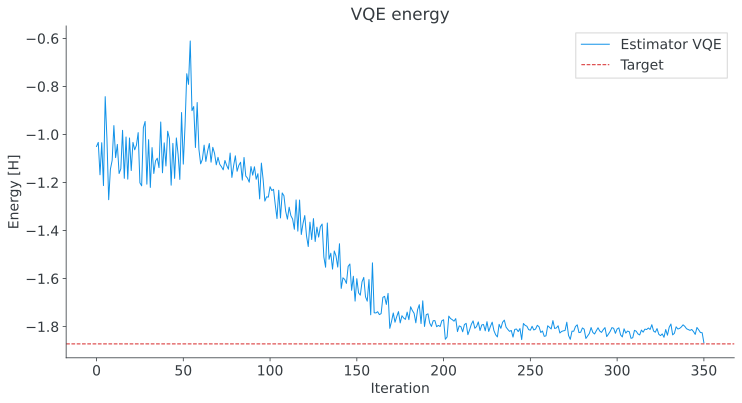

In [6]:
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 14

# Plot energy and reference value
plt.figure(figsize=(12, 6))
plt.plot(log.values, label="Estimator VQE")
plt.axhline(y=real_solution.groundenergy, color="tab:red", ls="--", label="Target")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

In [7]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.8.0'

In [10]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright